# Desafío - Mecanismos de Votación

Para esta actividad desarrollaremos un ensamble heterogéneo que prediga la popularidad o
impopularidad de contenido en línea de un sitio web

### Ejercicio 1 - Preparación del Ambiente de Trabajo

#### 1.1

##### 1.1.1 Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
plt.style.use('seaborn-v0_8-pastel')
plt.rcParams['figure.figsize'] = (12, 8)

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from helpers import identify_high_correlations as ihc
from helpers import plot_classification_report as pcr

##### 1.1.2

* A continuación se le presenta un código que agrupa las variables por grupos. Cada
uno de éstos hace referencia a alguna característica de los registros en la base de
datos. Genere una análisis descriptivo de cada uno de los atributos. Puede utilizar la
función grid_plot_batch que se encuentra en el archivo helpers.py

In [2]:
df = pd.read_csv('OnlineNewsPopularity/OnlineNewsPopularity.csv')

In [3]:
df.columns

Index(['url', ' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sent

In [4]:
# las etiquetas de las columnas presentan un espacio extra, con ésto lo podemos eliminar
df.columns = [i.replace(' ', '') for i in df.columns]
# eliminamos el string de url que no sirve para el análisis
df = df.loc[:, 'n_tokens_title':'shares']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 59 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   n_tokens_title                 39644 non-null  float64
 1   n_tokens_content               39644 non-null  float64
 2   n_unique_tokens                39644 non-null  float64
 3   n_non_stop_words               39644 non-null  float64
 4   n_non_stop_unique_tokens       39644 non-null  float64
 5   num_hrefs                      39644 non-null  float64
 6   num_self_hrefs                 39644 non-null  float64
 7   num_imgs                       39644 non-null  float64
 8   num_videos                     39644 non-null  float64
 9   average_token_length           39644 non-null  float64
 10  num_keywords                   39644 non-null  float64
 11  data_channel_is_lifestyle      39644 non-null  float64
 12  data_channel_is_entertainment  39644 non-null 

In [6]:
# generamos el conjunto de variables
qnty = df.filter(regex='^n_', axis=1)
channel = df.filter(regex='^data_', axis=1)
days = df.filter(regex=re.compile("weekday|weekend"), axis=1)
sentiments =df.filter(regex=re.compile("negative|positive|subjectivity"), axis=1)
lda = df.filter(regex='^LDA_\d', axis=1)
keywords = df.filter(regex='^kw_', axis=1)

In [7]:
np.max(df['data_channel_is_bus'])

1.0

In [8]:
def low_resource_graph(df, cols,figsize=(10, 8), dpi=100,sep_plot=.4): 
    rows = int(np.ceil(df.shape[1] / cols))   
    fig = plt.figure(figsize=figsize,dpi=dpi)
    fig.subplots_adjust(hspace=sep_plot)
    for n, i in enumerate(df.columns):
        plt.subplot(rows, cols, n + 1)
        plt.axvline(np.mean(df[i]), color='k', linestyle='--', linewidth=3, alpha=0.5, label='media')
        plt.axvline(np.median(df[i]), color='yellow', linestyle='-', linewidth=3, alpha=0.5, label='mediana')
        plt.axvline(np.max(df[i]), color='red', linestyle='-', linewidth=3, alpha=0.5, label='max')
        plt.axvline(np.min(df[i]), color='green', linestyle='-', linewidth=3, alpha=0.5, label='min')
        df[i].plot(kind='hist',alpha=0.8, label='valores')
        plt.title(i)
    plt.legend( ncol = 3)

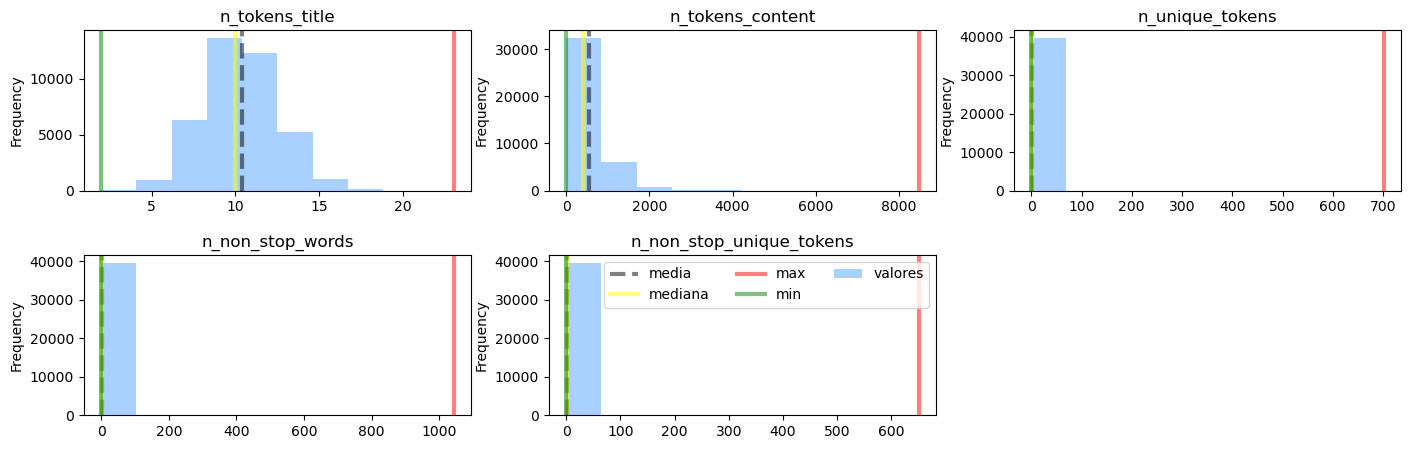

In [9]:
low_resource_graph(qnty, 3,figsize=(17, 5), dpi=100)

* Alta concentracion en la media para todas las variables. para los 3 ultimos graficos la media y concentracion de datos es cercana a 0 con valores entre 0 y 1, sin embargo presentan valores entre 0 y 1000 en general.
* notar que la media y la mediana son similares a simple vista.
* n_tokens_title, muestra un comportamiento simetrico-normal, n_tokens_content, no es normal.Un cambio logaritmico puede mejorar bastante su comportamiento.

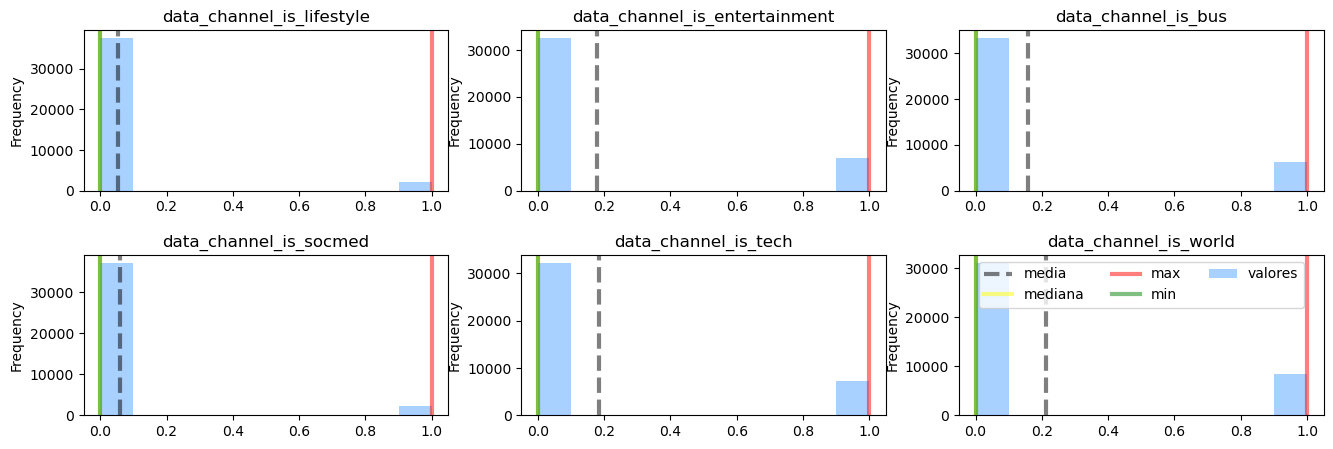

In [10]:
low_resource_graph(channel, 3,figsize=(16, 5), dpi=100)

* Nos encontramos frente a una variable BINARIA, donde para todos la concentracion esta en el 0

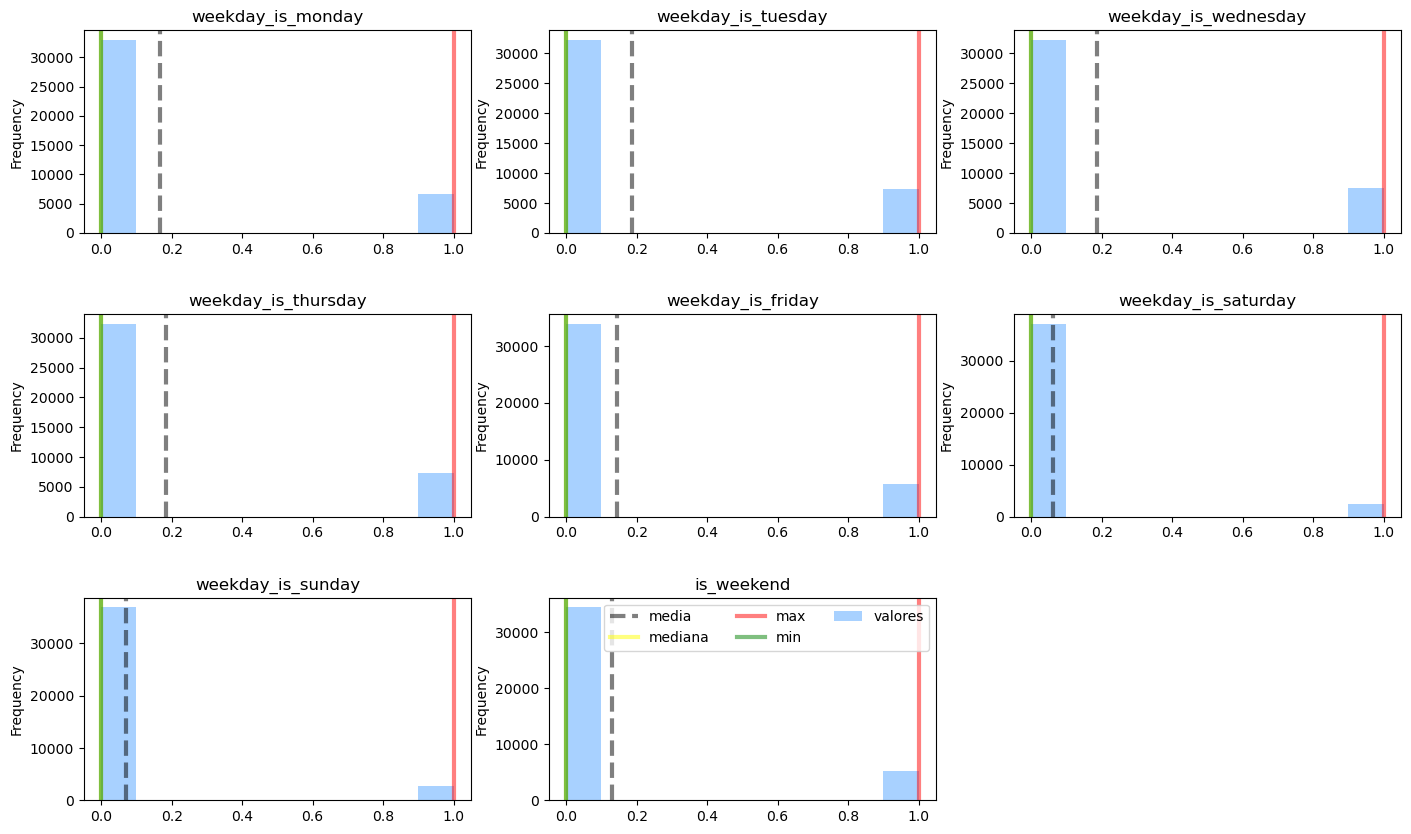

In [11]:
low_resource_graph(days, 3,figsize=(17, 10), dpi=100)

* Nos encontramos frente a una variable BINARIA, donde para todos la concentracion esta en el 0

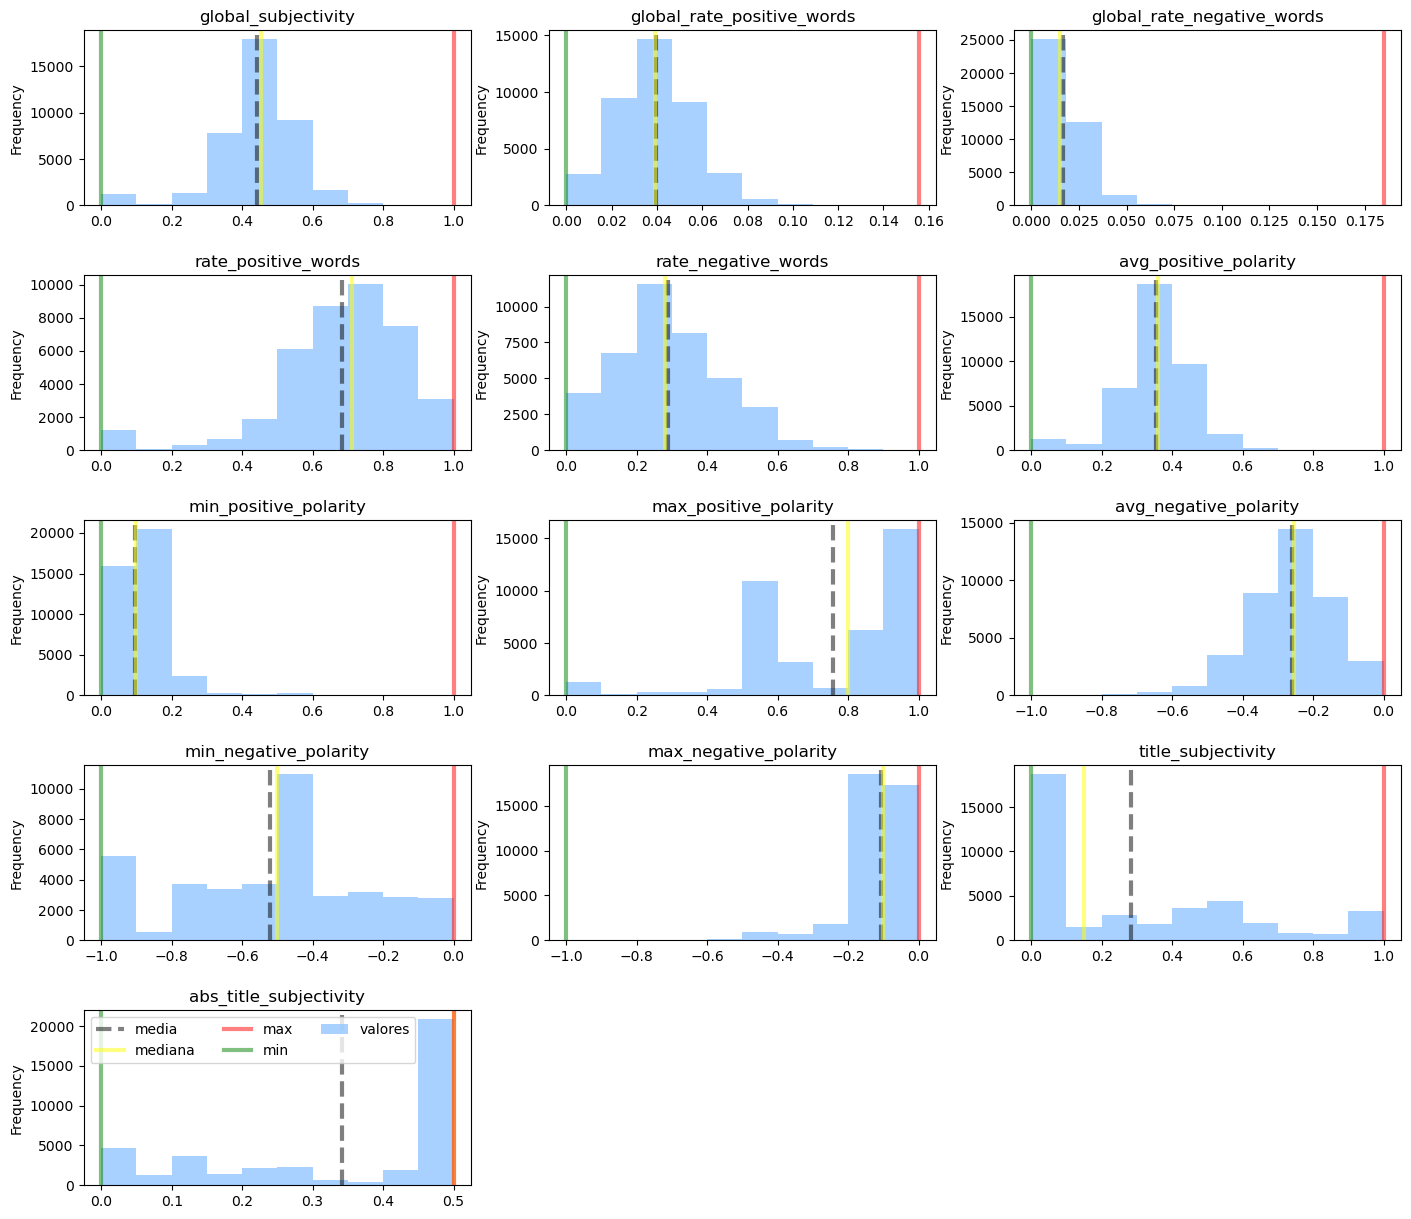

In [12]:
low_resource_graph(sentiments, 3,figsize=(17, 15), dpi=100)

* Variables con comportamiento simetrico normal, la mejor pareciera ser global subjetivity, dado la simetria entre el maximo y el minimo, ademas de su media y mediana similares.
* ademas de la variable ya mencionada en general muestan un comportamiento regular, a exepcion de title subjetivity que muestra una media muy distinta a la mediana, y un sesgo cargado a los valores bajos.

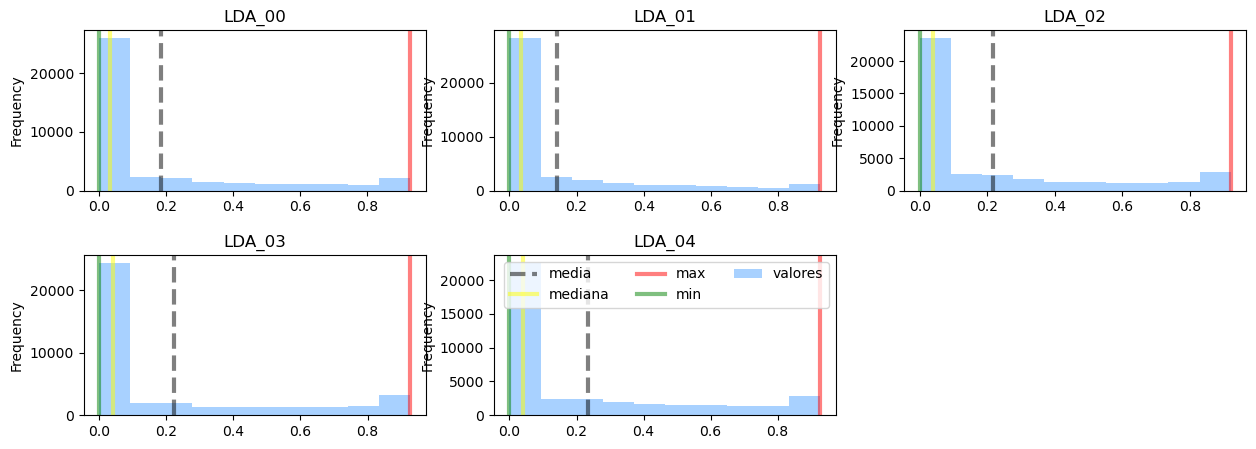

In [13]:
low_resource_graph(lda, 3,figsize=(15, 5), dpi=100)

* todas las variables presentan sesgo hacia valores bajos.

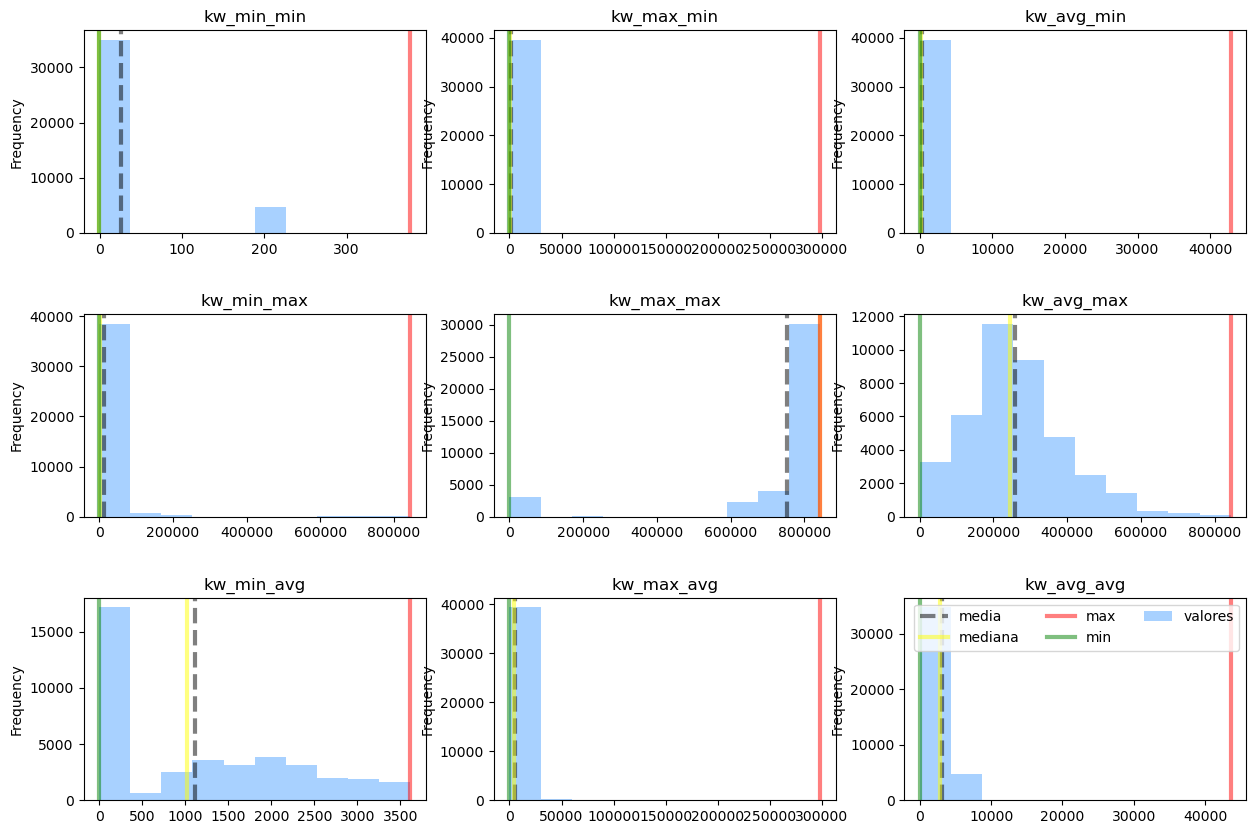

In [14]:
low_resource_graph(keywords, 3,figsize=(15, 10), dpi=100)

* kw_avg_max tiene un buen comportamiento simetrico con media y mediana similares, ademas simetria casi normal.
* las demas variables tienen un sesgo muy alto o concentraciones de datos con outliers, muy lejanos.

* Dada la naturaleza de los atributos, es probable que algunas mediciones estén
correlacionadas entre sí. Para ello, genere un diagnóstico previo de multicolinealidad
utilizando la función identify_high_correlations que se encuentra en el archivo
helpers.py. Para todos aquellos atributos que tengan una correlación de .8, reporte
sus nombres.

#### 1.2

* Dada la naturaleza de los atributos, es probable que algunas mediciones estén
correlacionadas entre sí. Para ello, genere un diagnóstico previo de multicolinealidad
utilizando la función identify_high_correlations que se encuentra en el archivo
helpers.py. Para todos aquellos atributos que tengan una correlación de .8, reporte
sus nombres

In [15]:
tmp_corr = ihc(df, threshold=.8)
tmp_corr

,variable,var2,value
179,n_non_stop_words,n_unique_tokens,0.999572
238,n_non_stop_unique_tokens,n_unique_tokens,0.999852
239,n_non_stop_unique_tokens,n_non_stop_words,0.999532
1139,kw_avg_min,kw_max_min,0.940529
1256,kw_max_max,kw_min_min,-0.857226
1499,kw_avg_avg,kw_max_avg,0.811864
1678,self_reference_avg_sharess,self_reference_min_shares,0.818907
1679,self_reference_avg_sharess,self_reference_max_shares,0.853480
2317,LDA_02,data_channel_is_world,0.836618


In [16]:
corr_dot8 = tmp_corr['variable'].values.tolist()
corr_dot8

['n_non_stop_words',
 'n_non_stop_unique_tokens',
 'n_non_stop_unique_tokens',
 'kw_avg_min',
 'kw_max_max',
 'kw_avg_avg',
 'self_reference_avg_sharess',
 'self_reference_avg_sharess',
 'LDA_02']

#### 1.3

* Antes de generar los conjuntos de entrenamiento y validación, pre procese los datos
con los siguientes pasos:

##### 1.3.1

* Recodifique la variable shares en una variable binaria que identifique como 1
todos los registros con más de 1400 "compartir" y 0 de lo contrario. Para
evitar multicolinealidad, elimine la variable shares posteriormente.

In [17]:
df['shares_bin'] = np.where(df['shares']>1400,1,0)

In [18]:
#verificar
df['shares_bin'].value_counts()[1] == df['shares'].loc[df['shares']>1400].shape[0]

True

In [19]:
df_bin =df.drop(columns='shares')

In [20]:
df_bin.shape

(39644, 59)

##### 1.3.2

* Elimine todas las variables que presentaban una correlación mayor a .8. Este
paso es para evitar la multicolinealidad de los atributos.

In [21]:
df_bin = df_bin.drop(columns=corr_dot8)

In [22]:
df_bin.shape

(39644, 52)

##### 1.3.3

* Genere un análisis de Componentes Principales para extraer las principales
30 dimensiones. Guarde estas dimensiones en un nuevo objeto.

In [23]:
y = df_bin['shares_bin']

In [24]:
X = df_bin.drop(columns='shares_bin')

In [25]:

dimred = PCA(n_components = 30)
project_x = dimred.fit_transform(X)

In [26]:
project_x

array([[-2.56883557e+05,  3.93581028e+04, -7.15107483e+02, ...,
        -1.35842497e-01,  1.95915216e-04, -1.22038009e-01],
       [-2.56902239e+05,  3.93884275e+04, -1.32441967e+03, ...,
         1.47095010e-01, -8.13688195e-02, -2.11682185e-01],
       [-2.56867669e+05,  3.93323075e+04, -1.96692912e+02, ...,
        -4.91517593e-02, -2.86248276e-02,  2.07701920e-01],
       ...,
       [ 3.40149599e+04, -1.41401969e+04, -1.10381002e+04, ...,
         1.34893112e-03, -2.70666709e-02, -1.56569604e-01],
       [-7.67746342e+03, -1.18399207e+04, -1.09050637e+04, ...,
        -7.86109934e-02, -3.23709949e-02, -4.72697626e-02],
       [ 1.43299962e+05,  1.66767951e+05, -4.49821928e+03, ...,
        -1.55028840e-01,  4.14788635e-02,  1.26147054e-01]])

In [27]:
df_reduced = pd.DataFrame(project_x)

In [28]:
df_reduced

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-256883.556780,39358.102842,-715.107483,-675.982864,-4037.273826,526.212703,339.997605,-423.078072,-105.882239,-2.558931,...,-0.177233,-0.027875,0.076015,0.754322,0.130501,-0.240216,0.163335,-0.135842,0.000196,-0.122038
1,-256902.239254,39388.427538,-1324.419672,-1021.526057,-4026.912676,522.472500,339.327816,-387.375808,-105.283127,-4.022484,...,0.592850,-0.170436,-0.133632,0.893599,-0.104273,-0.171966,0.015550,0.147095,-0.081369,-0.211682
2,-256867.668930,39332.307489,-196.692912,-382.025010,-4046.123848,529.459999,340.359378,-430.854556,-106.006295,-3.465349,...,0.387925,-0.115308,-0.063300,0.893855,-0.094539,-0.182748,0.489726,-0.049152,-0.028625,0.207702
3,-256902.328524,39388.489448,-1324.323377,-1021.924528,-4027.333693,523.261696,336.765286,-111.386939,-100.823200,-1.715893,...,-0.389151,0.023495,0.087133,0.833770,-0.398593,-0.202157,0.017307,-0.053012,0.016763,-0.017556
4,-256428.973921,38604.785382,14206.833701,-4770.099062,-4462.030333,651.699071,335.406255,418.254842,-92.451864,9.400788,...,0.090101,-0.017093,0.110249,0.823460,0.414338,-0.245175,0.078988,0.079079,-0.075262,-0.021122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,117075.775194,-12162.193414,34085.119262,-2908.208269,-3214.321969,1011.102818,-1038.878221,-193.477461,-1.912040,-1.491568,...,-0.251439,0.847699,-0.139019,-0.171123,-0.247546,-0.109629,-0.009508,-0.197905,-0.004467,0.035337
39640,-66584.096003,6796.841112,-6071.533374,375.122923,124.917787,-697.088259,-752.303046,-242.878553,-50.866761,0.746148,...,0.727046,0.634715,-0.350675,-0.318164,0.794569,-0.183580,-0.257333,0.805460,0.119126,-0.042128
39641,34014.959890,-14140.196861,-11038.100156,-123.863124,898.283245,-908.029989,-567.229087,-87.516296,-17.729171,14.824550,...,-0.190123,0.800340,-0.219973,-0.266666,0.182267,-0.159011,0.362113,0.001349,-0.027067,-0.156570
39642,-7677.463424,-11839.920698,-10905.063719,-733.750759,-2336.459776,-99.272682,1021.764001,144.914574,-20.401470,-2.569667,...,-0.181231,0.817242,-0.263111,-0.195889,-0.101956,-0.186306,-0.124291,-0.078611,-0.032371,-0.047270


In [29]:
X = df_reduced

### Ejercicio 2 - Evaluación de modelos individuales

#### 2.1  A continuación generará una serie de modelos que se incorporarán posteriormente al comité de votación. Para ello, se solicita que:

##### 2.1.1 Importe los módulos correctamente.

In [30]:
# Módulos de modelos
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

##### 2.1.2 Para cada uno de ellos, genere un reporte en las métricas de desempeño respecto a Precision, Recall, F1. Puede hacer uso de la función plot_classification_report disponible en el archivo helpers.py.

In [31]:
X_eval, X_holdout, y_eval, y_holdout = train_test_split(X, y, test_size=.33, random_state=1991)

In [32]:
# Separamos la muestra de entrenamiento entre entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X_eval, y_eval, test_size=.33, random_state=1991)
print(f'Registros holdout: {X_holdout.shape[0]} / Atributos holdout: {X_holdout.shape[1]}')
print(f'Registros training: {X_train.shape[0]} / Atributos training: {X_train.shape[1]}')
print(f'Registros testing: {X_test.shape[0]} / Atributos holdout: {X_test.shape[1]}')

Registros holdout: 13083 / Atributos holdout: 30
Registros training: 17795 / Atributos training: 30
Registros testing: 8766 / Atributos holdout: 30


In [33]:
#logistic
model_log = LogisticRegression(max_iter=300, random_state=1991)
yhat_logistic = model_log.fit(X_train, y_train).predict(X_test)
#Kmeans
model_KM = KMeans(n_clusters=2, n_init='auto',random_state=1991)
yhat_kmeans = model_KM.fit(X_train, y_train).predict(X_test)
#Desition Tree 1
model_tree1 = DecisionTreeClassifier(max_depth=1, random_state=1991)
yhat_tree1 = model_tree1.fit(X_train, y_train).predict(X_test)
#desition Tree 4
model_tree4 = DecisionTreeClassifier(max_depth=4, random_state=1991)
yhat_tree4 = model_tree4.fit(X_train, y_train).predict(X_test)

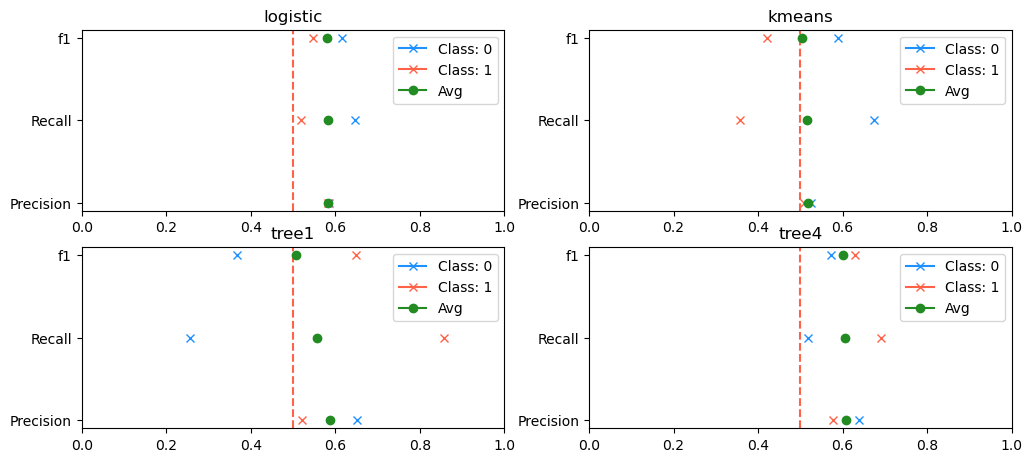

In [34]:
pred = [yhat_logistic, yhat_kmeans, yhat_tree1, yhat_tree4]
pred_id = ['logistic', 'kmeans', 'tree1', 'tree4']
for n, i in enumerate(pred):
    plt.subplot(3, 2, n + 1)
    plt.title(pred_id[n])
    plt.axvline(x=.5, color='Tomato', linestyle='--')
    pcr(y_test, i)
    plt.legend()
    

##### 2.1.3 Comente el desempeño general de cada uno

* tree1 tiene el peor desempeño en capturar los negativos '0', sin embargo logra el mejor puntaje en la captura de los positivos.
* Lo modelos que logran el mayor F1 son el logistico y el tree4, solo cambia la clase que logran capturar, logistico 0 y tree4 1. Ambos logran ser estables.

### Ejercicio 3 - Entrenamiento de Comité

#### 3.1 Entrene el comité de clasificadores sin modificar el esquema de votación.

Dado que kmeans no esta hecho para clasificacion el modulo voting no deja utilizarlo como estimador, por ende lo dejamos fuera.

In [35]:
estimators = [
    ('Logistic Regression', LogisticRegression(max_iter=300, random_state=1991)),
    #('Kmeans',  KMeans(n_clusters=2, n_init='auto',random_state=1991)),
    ('Decision Tree Classifier', DecisionTreeClassifier(max_depth=1, random_state=1991)),
    ('Decision Tree Classifier 4', DecisionTreeClassifier(max_depth=4, random_state=1991))
]

In [36]:
voting_classifier = VotingClassifier(estimators).fit(X_train, y_train)

In [37]:
yhat_voting = voting_classifier.predict(X_test)

#### 3.2 Reporte el desempeño a nivel de cada clase para cada métrica

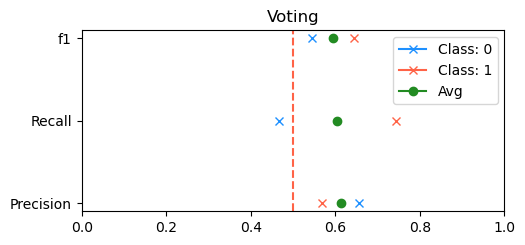

In [38]:
plt.subplot(3, 2, n + 1)
plt.title('Voting')
plt.axvline(x=.5, color='Tomato', linestyle='--')
pcr(y_test, yhat_voting)
plt.legend()

* El modelo tiene problemas para clasificar la clase 0
* esta a un nivel promedio similar al modelo decition tree con profundidad 4 

### Ejercicio 4 - Calibración de Comité con Ponderadores

#### 4.1 En base al comportamiento de los clasificadores individuales del ensamble, proponga dos esquemas de ponderación para mejorar el desempeño del modelo

In [57]:
w1 = [2/5, 1/5, 2/5]
w2 = [0.1, 0.1, 0.8]

In [58]:
voting_classifier2 = VotingClassifier(estimators, weights=w1)

In [59]:
voting_classifier3 = VotingClassifier(estimators, weights=w2)

In [60]:
voting_classifier2.fit(X_train, y_train)

VotingClassifier(estimators=[('Logistic Regression',
                              LogisticRegression(max_iter=300,
                                                 random_state=1991)),
                             ('Decision Tree Classifier',
                              DecisionTreeClassifier(max_depth=1,
                                                     random_state=1991)),
                             ('Decision Tree Classifier 4',
                              DecisionTreeClassifier(max_depth=4,
                                                     random_state=1991))],
                 weights=[0.4, 0.2, 0.4])

In [61]:
voting_classifier3.fit(X_train, y_train)

VotingClassifier(estimators=[('Logistic Regression',
                              LogisticRegression(max_iter=300,
                                                 random_state=1991)),
                             ('Decision Tree Classifier',
                              DecisionTreeClassifier(max_depth=1,
                                                     random_state=1991)),
                             ('Decision Tree Classifier 4',
                              DecisionTreeClassifier(max_depth=4,
                                                     random_state=1991))],
                 weights=[0.1, 0.1, 0.8])

#### 4.2 Reporte el desempeño del mejor ensamble heterogéneo

In [62]:
yhat_vcl2 = voting_classifier2.predict(X_test)
yhat_vcl3 = voting_classifier3.predict(X_test)

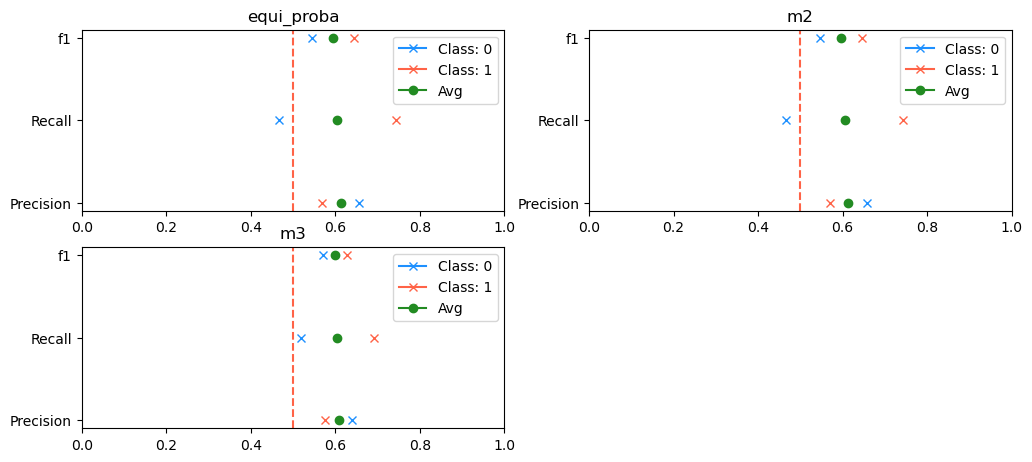

In [63]:
pred = [yhat_voting, yhat_vcl2, yhat_vcl3]
pred_id = ['equi_proba', 'm2', 'm3']
for n, i in enumerate(pred):
    plt.subplot(3, 2, n + 1)
    plt.title(pred_id[n])
    plt.axvline(x=.5, color='Tomato', linestyle='--')
    pcr(y_test, i)
    plt.legend()
    

El tercer modelo con los pesos w2 = [0.1, 0.1, 0.8], donde se pondera con .8 al random forest 4 obtiene el mejor resultado en cuanto a su capacidad de predecir correctamente ambas clases y disminuye la variabilidad de las predicciones.